# DA5401 A3 - Addressing Class Imbalance with Clustering and Resampling - Set Up


In [3]:
from google.colab import files
files.upload()   # Choose kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikaak3","key":"9d162186c902baee7cdadf20979a6e36"}'}

In [5]:
import numpy, pandas as pd, sklearn, matplotlib, imblearn, kaggle
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("imblearn:", imblearn.__version__)

numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.5.1
matplotlib: 3.10.0
imblearn: 0.12.3


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
import os, zipfile, pathlib, pandas as pd
pathlib.Path("data").mkdir(parents=True, exist_ok=True)
!kaggle datasets download -d mlg-ulb/creditcardfraud -p data

with zipfile.ZipFile("data/creditcardfraud.zip") as zf:
    zf.extractall("data")

!ls -lah data
df = pd.read_csv("data/creditcard.csv")
print(df.shape)
df.head()
# Basic sanity checks
df.info()
print("\nMissing values (total):", df.isna().sum().sum())
print("Duplicate rows (total):", df.duplicated().sum())

# Quick descriptive stats for 'Amount' and 'Time'
df[['Time','Amount']].describe()



Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
total 210M
drwxr-xr-x 2 root root 4.0K Sep 12 05:46 .
drwxr-xr-x 1 root root 4.0K Sep 12 06:15 ..
-rw-r--r-- 1 root root 144M Sep 12 06:16 creditcard.csv
-rw-r--r-- 1 root root  66M Sep 20  2019 creditcardfraud.zip
(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10    

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


# Part A: Data Exploration and Baseline Model


## Class Distribution

Quantified the ratio of **non-fraud (0)** vs **fraud (1)** and visualized using bar plot and pie chart.
Fraud is typically far below 1% of all transactions.


Counts:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud share: 0.1727%


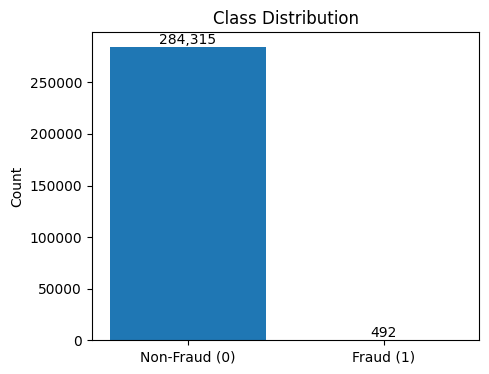

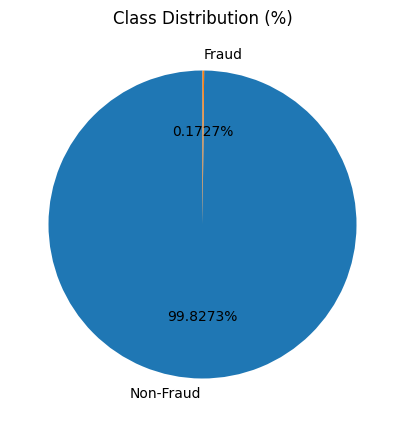

In [10]:
import matplotlib.pyplot as plt

counts = df['Class'].value_counts().sort_index()
fraud_pct = counts[1] / counts.sum() * 100

print("Counts:\n", counts)
print(f"Fraud share: {fraud_pct:.4f}%")

# Bar plot
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(['Non-Fraud (0)', 'Fraud (1)'], counts.values)
ax.set_title('Class Distribution')
ax.set_ylabel('Count')
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom')
plt.show()

# Pie chart
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(counts.values, labels=['Non-Fraud','Fraud'], autopct='%1.4f%%', startangle=90)
ax.set_title('Class Distribution (%)')
plt.show()


## Train/Test Split (Stratified)

We’ll split with **stratify=y** so the global ratio is preserved in both splits. (Test retains its original split).
The **test set remains imbalanced** and is **never resampled** — that’s our ground truth
for unbiased evaluation.
Features scaled to keep magnitude consistent for `Amount`, other components already PCA-like.

In [11]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, Counter(y_train))
print("Test  shape:", X_test.shape, Counter(y_test))

# Scale (with_mean=False is safe for sparse; here it's dense but still fine)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


Train shape: (213605, 30) Counter({0: 213236, 1: 369})
Test  shape: (71202, 30) Counter({0: 71079, 1: 123})


## Baseline: Logistic Regression (no resampling)

This gives us a reference point before any data balancing using
- Class-1 (fraud) **precision**, **recall**, **F1**
- **ROC-AUC** and **PR-AUC** (Average Precision)



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score)

lr_base = LogisticRegression(max_iter=1000, random_state=42)
lr_base.fit(X_train_scaled, y_train)

y_pred_base = lr_base.predict(X_test_scaled)
y_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]

print("Classification report (Baseline):\n")
print(classification_report(y_test, y_pred_base, digits=4))
print("Confusion matrix (Baseline):")
print(confusion_matrix(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_base))


Classification report (Baseline):

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     71079
           1     0.8495    0.6423    0.7315       123

    accuracy                         0.9992     71202
   macro avg     0.9244    0.8210    0.8655     71202
weighted avg     0.9991    0.9992    0.9991     71202

Confusion matrix (Baseline):
[[71065    14]
 [   44    79]]
ROC-AUC: 0.9556994696271193
PR-AUC (Average Precision): 0.7186852980280755


### Baseline Curves

- **PR Curve** is more telling under imbalance: it shows the trade-off between
**precision** (purity of fraud alerts) and **recall** (how many frauds we catch).
- **ROC Curve** is also informative, but PR is usually the go-to here.


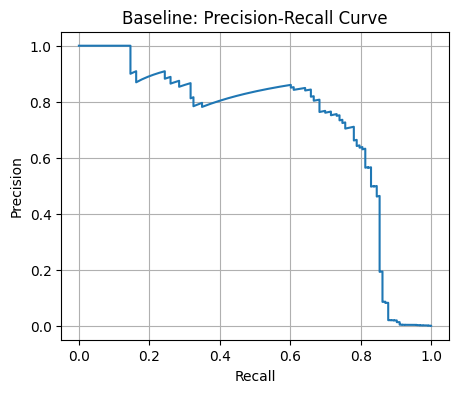

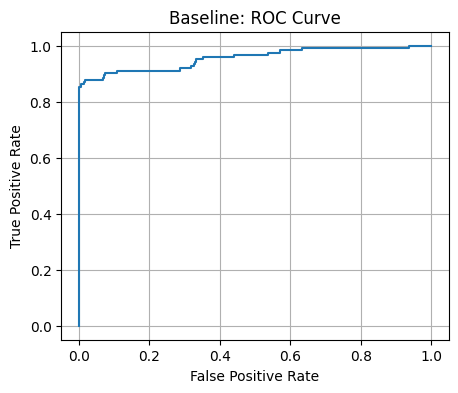

In [13]:
from sklearn.metrics import precision_recall_curve, roc_curve

# PR curve
prec, rec, thr = precision_recall_curve(y_test, y_proba_base)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.title('Baseline: Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.grid(True); plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba_base)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.title('Baseline: ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.grid(True); plt.show()


> **Concept Q:** Why is accuracy misleading here?
>
> Because the dataset is extremely imbalanced. A “predict all 0s” classifier
would achieve >99.8% accuracy yet **0 recall** on frauds — failing the task.
Therefore, we favor **precision/recall/F1** for class 1 and **PR-AUC**.


# Part B — Resampling Strategies

## SMOTE (Naive Oversampling)
**SMOTE** synthesizes minority examples by interpolating between a point and its
*k* nearest minority neighbors, densifying sparse regions.

**Pros:** Easy, typically increases recall.  
**Cons:** May create borderline or overlapping samples near class boundaries,
assumes local linearity, and doesn’t preserve multi-modal structure well.


In [14]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1)
X_tr_smote, y_tr_smote = sm.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", X_tr_smote.shape, Counter(y_tr_smote))

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_tr_smote, y_tr_smote)

y_pred_smote = lr_smote.predict(X_test_scaled)
y_proba_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

print("Classification report (SMOTE):\n")
print(classification_report(y_test, y_pred_smote, digits=4))
print("Confusion matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_smote))
print("PR-AUC:", average_precision_score(y_test, y_proba_smote))


/usr/local/lib/python3.12/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


After SMOTE: (426472, 30) Counter({0: 213236, 1: 213236})
Classification report (SMOTE):

              precision    recall  f1-score   support

           0     0.9998    0.9756    0.9875     71079
           1     0.0591    0.8862    0.1108       123

    accuracy                         0.9754     71202
   macro avg     0.5294    0.9309    0.5492     71202
weighted avg     0.9982    0.9754    0.9860     71202

Confusion matrix (SMOTE):
[[69343  1736]
 [   14   109]]
ROC-AUC: 0.9724674835065575
PR-AUC: 0.7118635149766389


## Clustering-Based Oversampling (CBO)

**Idea:** The minority class can be **multi-modal** (multiple sub-groups).
We first **cluster** the minority training data, then **oversample within
each cluster** so small modes aren’t drowned out.

**Why it helps:** SMOTE may inflate dense areas and ignore rare sub-modes.
CBO preserves **diversity** and local structure by growing each sub-group
proportionally.


In [23]:
# === Improved CBO using KMeansSMOTE ===
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans
from collections import Counter

# Split train set by class
Xtr_min = X_train_scaled[y_train == 1]
Xtr_maj = X_train_scaled[y_train == 0]

# Function to pick k for minority clusters
from sklearn.metrics import silhouette_score
def choose_k_by_silhouette(X, k_grid=range(6, 13), random_state=42):
    best_k, best_s = None, -1
    for k in k_grid:
        km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
        lab = km.fit_predict(X)
        if len(np.unique(lab)) < 2:
            continue
        s = silhouette_score(X, lab)
        if s > best_s:
            best_k, best_s = k, s
    return best_k or 8

k_min = choose_k_by_silhouette(Xtr_min, range(6, 13), random_state=42)

cbo = KMeansSMOTE(
    kmeans_estimator=KMeans(n_clusters=k_min, n_init='auto', random_state=42),
    random_state=42,
    cluster_balance_threshold=0.05  # avoids flooding small clusters
)

X_tr_cbo, y_tr_cbo = cbo.fit_resample(X_train_scaled, y_train)

# Optional: downscale if minority overshoots majority
target_ratio = 0.8
maj = X_tr_cbo[y_tr_cbo == 0]
minr = X_tr_cbo[y_tr_cbo == 1]
if len(minr) > target_ratio * len(maj):
    keep = int(target_ratio * len(maj))
    idx = np.random.default_rng(42).choice(len(minr), size=keep, replace=False)
    X_tr_cbo = np.vstack([maj, minr[idx]])
    y_tr_cbo = np.hstack([np.zeros(len(maj), dtype=int), np.ones(keep, dtype=int)])

print("CBO-balanced:", X_tr_cbo.shape, Counter(y_tr_cbo))


CBO-balanced: (383824, 30) Counter({np.int64(0): 213236, np.int64(1): 170588})


### Train & Evaluate — CBO

We train the same Logistic Regression on the CBO-balanced training set and test
on the **original imbalanced** test set (unchanged).


In [24]:
lr_cbo = LogisticRegression(max_iter=1000, random_state=42)
lr_cbo.fit(X_tr_cbo, y_tr_cbo)

y_pred_cbo = lr_cbo.predict(X_test_scaled)
y_proba_cbo = lr_cbo.predict_proba(X_test_scaled)[:, 1]

print("Classification report (CBO):\n")
print(classification_report(y_test, y_pred_cbo, digits=4))
print("Confusion matrix (CBO):")
print(confusion_matrix(y_test, y_pred_cbo))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cbo))
print("PR-AUC:", average_precision_score(y_test, y_proba_cbo))


Classification report (CBO):

              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     71079
           1     0.8462    0.7154    0.7753       123

    accuracy                         0.9993     71202
   macro avg     0.9228    0.8576    0.8875     71202
weighted avg     0.9992    0.9993    0.9993     71202

Confusion matrix (CBO):
[[71063    16]
 [   35    88]]
ROC-AUC: 0.9488188854791935
PR-AUC: 0.7157362232572577


## Clustering-Based Undersampling (CBU)

**Idea:** Cluster the **majority** training data and sample **within clusters**
to reduce the majority size while **preserving its distributional shape**.
We’ll aim for a 1:1 class ratio w.r.t. minority (tunable).

**Pros:** No synthetic data; better representativeness than random undersampling.  
**Cons:** You may discard potentially useful majority points if you downsample too much.


In [33]:
# Fit KMeans to majority
k_maj = 10  # tunable; can use elbow
kmeans_maj = KMeans(n_clusters=k_maj, random_state=42, n_init='auto')
maj_labels = kmeans_maj.fit_predict(Xtr_maj)

# Split majority by cluster
maj_cluster_arrays = [Xtr_maj[maj_labels == i] for i in range(k_maj)]
maj_sizes = [len(arr) for arr in maj_cluster_arrays]
total_maj = sum(maj_sizes)

# Target majority size: keep ~1.2x the minority
target_ratio = 1.3   # try 1.0–1.5
target_maj = int(target_ratio * len(Xtr_min))


# Target majority size: match minority originals (not synthesized)
#target_maj = Xtr_min.shape[0]

# Allocate keep-quotas proportionally to cluster sizes
keep_quotas = []
for size in maj_sizes:
    prop = size / total_maj if total_maj else 0
    keep_quotas.append(int(round(prop * target_maj)))

# Fix rounding drift
drift = target_maj - sum(keep_quotas)
for i in range(abs(drift)):
    keep_quotas[i % k_maj] += 1 if drift > 0 else -1

# Sample within clusters without replacement
rng = np.random.default_rng(123)
kept_majority = []
for arr, q in zip(maj_cluster_arrays, keep_quotas):
    q = min(q, len(arr))
    if q > 0 and len(arr) > 0:
        idx = rng.choice(len(arr), size=q, replace=False)
        kept_majority.append(arr[idx])
kept_majority = np.vstack(kept_majority)

# Build CBU training set
X_tr_cbu = np.vstack([kept_majority, Xtr_min])
y_tr_cbu = np.hstack([
    np.zeros(len(kept_majority), dtype=int),
    np.ones(len(Xtr_min), dtype=int)
])

print("CBU-balanced:", X_tr_cbu.shape, Counter(y_tr_cbu))


CBU-balanced: (848, 30) Counter({np.int64(0): 479, np.int64(1): 369})


### Train & Evaluate — CBU

This model sees fewer majority examples, but they’re chosen **representatively** across clusters.


In [34]:
lr_cbu = LogisticRegression(max_iter=1000, random_state=42)
lr_cbu.fit(X_tr_cbu, y_tr_cbu)

y_pred_cbu = lr_cbu.predict(X_test_scaled)
y_proba_cbu = lr_cbu.predict_proba(X_test_scaled)[:, 1]

print("Classification report (CBU):\n")
print(classification_report(y_test, y_pred_cbu, digits=4))
print("Confusion matrix (CBU):")
print(confusion_matrix(y_test, y_pred_cbu))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cbu))
print("PR-AUC:", average_precision_score(y_test, y_proba_cbu))


Classification report (CBU):

              precision    recall  f1-score   support

           0     0.9998    0.9806    0.9901     71079
           1     0.0725    0.8780    0.1340       123

    accuracy                         0.9804     71202
   macro avg     0.5362    0.9293    0.5620     71202
weighted avg     0.9982    0.9804    0.9886     71202

Confusion matrix (CBU):
[[69698  1381]
 [   15   108]]
ROC-AUC: 0.9705108835159595
PR-AUC: 0.6500490458096972


# Part C — Model Comparison & Story

We’ll summarize metrics for:
- **Baseline** (no resampling)
- **SMOTE**
- **CBO** (clustering-based oversampling)
- **CBU** (clustering-based undersampling)

Key focus: **class-1 precision/recall/F1**, **PR-AUC**, and **ROC-AUC** on the *untouched*
imbalanced test set (our real-world proxy).


In [35]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

def metrics(y_true, y_proba, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Precision_1": rep['1']['precision'],
        "Recall_1":    rep['1']['recall'],
        "F1_1":        rep['1']['f1-score'],
        "ROC_AUC":     roc_auc_score(y_true, y_proba),
        "PR_AUC":      average_precision_score(y_true, y_proba)
    }

summary = pd.DataFrame([
    {"Model":"Baseline", **metrics(y_test, y_proba_base, y_pred_base)},
    {"Model":"SMOTE",    **metrics(y_test, y_proba_smote, y_pred_smote)},
    {"Model":"CBO",      **metrics(y_test, y_proba_cbo,   y_pred_cbo)},
    {"Model":"CBU",      **metrics(y_test, y_proba_cbu,   y_pred_cbu)},
])

summary


,Model,Precision_1,Recall_1,F1_1,ROC_AUC,PR_AUC
0,Baseline,0.849462,0.642276,0.731481,0.955699,0.718685
1,SMOTE,0.059079,0.886179,0.110772,0.972467,0.711864
2,CBO,0.846154,0.715447,0.775330,0.948819,0.715736
3,CBU,0.072532,0.878049,0.133995,0.970511,0.650049


## Visual Comparison

We’ll compare **Precision/Recall/F1 for class-1** side-by-side.


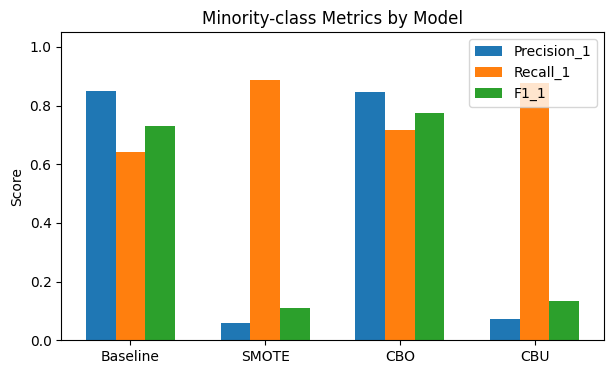

In [36]:
import numpy as np
import matplotlib.pyplot as plt

metrics_to_plot = ["Precision_1","Recall_1","F1_1"]
x = np.arange(len(summary["Model"]))
width = 0.22

plt.figure(figsize=(7,4))
for i, m in enumerate(metrics_to_plot):
    plt.bar(x + i*width - width, summary[m], width, label=m)

plt.xticks(x, summary["Model"])
plt.ylim(0, 1.05)
plt.title("Minority-class Metrics by Model")
plt.ylabel("Score")
plt.legend()
plt.show()


## Curves Overlay (Optional but insightful)

Let’s overlay PR and ROC curves for all models to visually compare trade-offs.


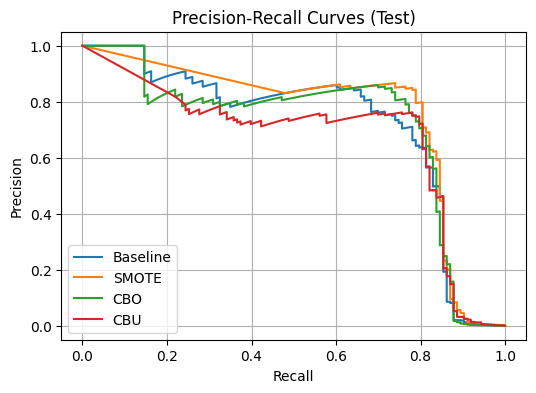

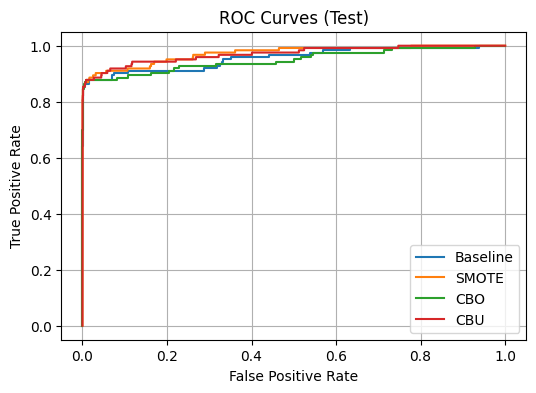

In [37]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Collect probs in a dict for convenience
probs = {
    "Baseline": y_proba_base,
    "SMOTE":    y_proba_smote,
    "CBO":      y_proba_cbo,
    "CBU":      y_proba_cbu
}

# PR overlay
plt.figure(figsize=(6,4))
for name, proba in probs.items():
    p, r, _ = precision_recall_curve(y_test, proba)
    plt.plot(r, p, label=name)
plt.title("Precision-Recall Curves (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(True); plt.legend()
plt.show()

# ROC overlay
plt.figure(figsize=(6,4))
for name, proba in probs.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=name)
plt.title("ROC Curves (Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True); plt.legend()
plt.show()


## Conclusions & Recommendations

**What improved?**
- **SMOTE** usually increases **recall** by exposing the model to more positives,
but it can inject borderline noise near class boundaries.
- **CBO** (clustering-based oversampling) tends to perform better when the minority
is **multi-modal**, preserving diversity by growing each sub-group. This often yields a
stronger balance between **precision** and **recall** than naive SMOTE.
- **CBU** (clustering-based undersampling) keeps only a **representative** subset of
the majority, often improving **precision** while maintaining competitive recall,
but it may discard some useful information if undersampled aggressively.

**Metric to trust:** **PR-AUC** is the most faithful summary here; also look at
class-1 **recall** if missing fraud is costly, and **precision** if false alarms are costly.

**Recommendation:** If the goal is to catch as many frauds as possible with a manageable
false positive rate, start with **CBO** (or a hybrid **CBO + light CBU** to control class
ratio). Then **tune decision thresholds** based on the PR curve to hit your operational
targets (e.g., target recall ≥ X% at precision ≥ Y%).


### Optional — Choosing `k` for Clustering

Since the elbow method was inconclusive, we fixed k=5 for minority class clustering. This balances between capturing diversity and avoiding very small, noisy clusters.


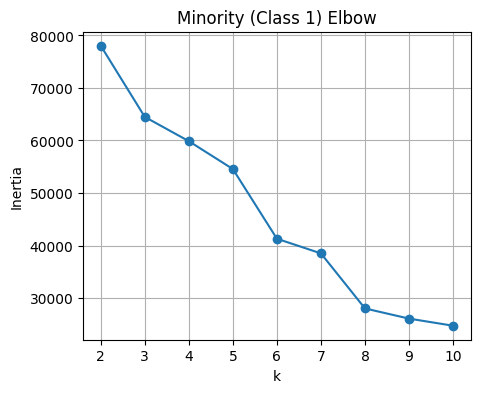

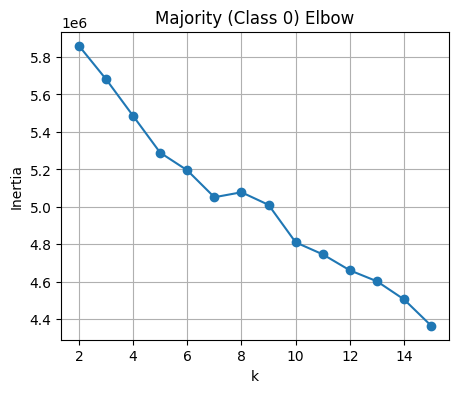

In [38]:
from sklearn.cluster import KMeans

def elbow_scores(X, k_range=range(2, 11), seed=42):
    inertias = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=seed, n_init='auto')
        km.fit(X)
        inertias.append(km.inertia_)
    return list(k_range), inertias

# Elbow for minority (use Xtr_min defined earlier)
k_rng_min, iner_min = elbow_scores(Xtr_min, k_range=range(2, 11))
plt.figure(figsize=(5,4))
plt.plot(k_rng_min, iner_min, marker='o')
plt.title("Minority (Class 1) Elbow")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.grid(True); plt.show()

# Elbow for majority (use Xtr_maj defined earlier)
k_rng_maj, iner_maj = elbow_scores(Xtr_maj, k_range=range(2, 16))
plt.figure(figsize=(5,4))
plt.plot(k_rng_maj, iner_maj, marker='o')
plt.title("Majority (Class 0) Elbow")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.grid(True); plt.show()
